# Introduction to NeRFs, 3D Rendering, and Novel View Synthesis

## What is NeRF?

Neural Radiance Fields (NeRFs) are an innovative approach to modeling 3D scenes and synthesizing novel views using a sparse set of 2D images. Developed by Mildenhall et al. in 2020, NeRFs revolutionized computer vision by leveraging neural networks to represent complex 3D geometry and appearances. By encoding a scene as a continuous volumetric field, NeRFs allow for the generation of highly realistic renderings from arbitrary viewpoints.

### Key Concepts in NeRF
1. **Scene Representation**:
   - Each point in 3D space is characterized by its color (RGB) and volumetric density.
   - The volumetric density determines how light interacts with the material, influencing transparency and opacity.

2. **Neural Network Parameterization**:
   - A fully connected neural network maps spatial coordinates (x, y, z) and view directions to radiance (color) and density.
   - The model learns this mapping through optimization, using pixel values from the input images as supervision.

3. **Volume Rendering**:
   - NeRF employs volume rendering techniques to integrate radiance and density along camera rays, producing pixel values for rendered images.

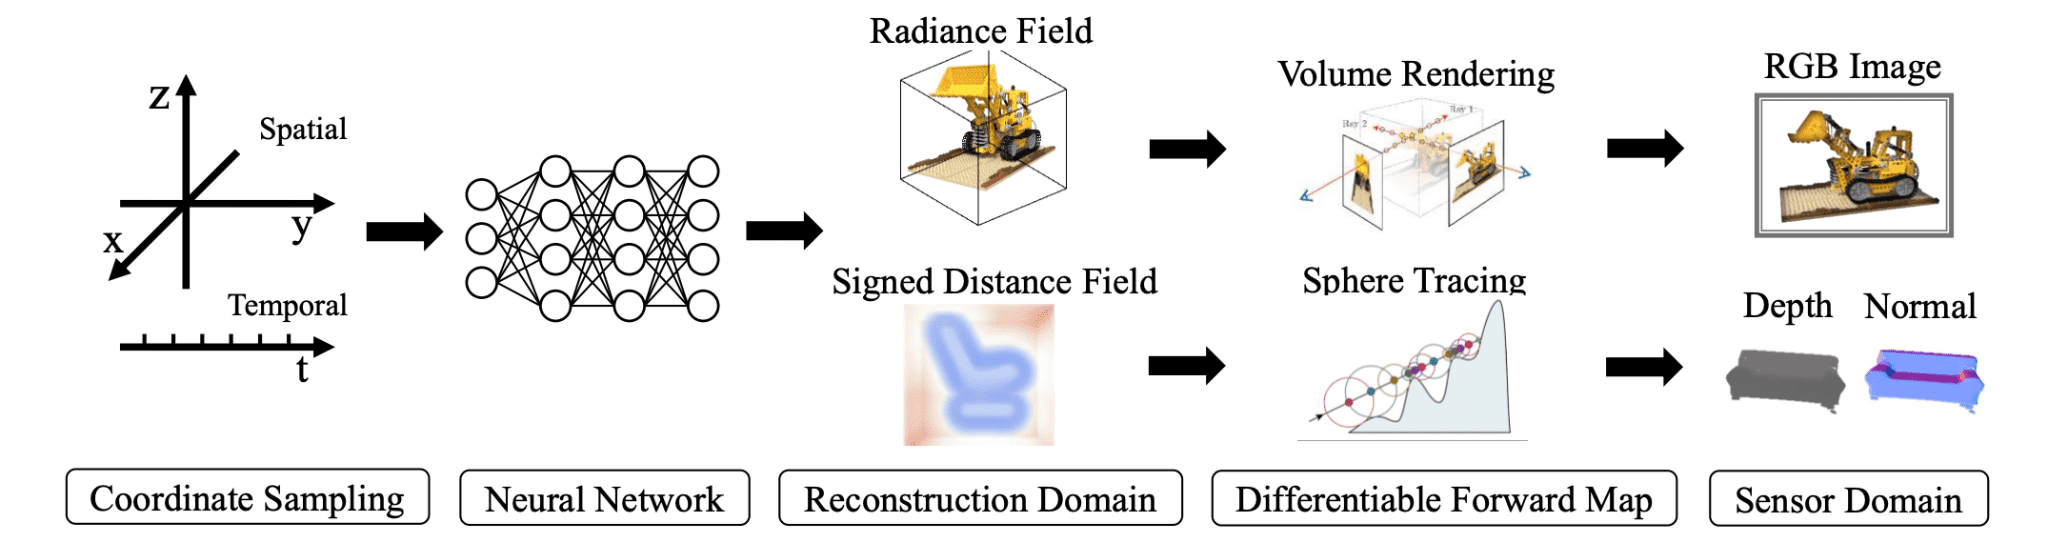

Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Ftheaisummer.com%2Fnerf%2F&psig=AOvVaw0unAExxbiSKWMaMWFUkNY1&ust=1734838969498000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCNi8nPr4t4oDFQAAAAAdAAAAABAE

---

## What is Ray Tracing?

Ray tracing is a rendering technique that simulates the physical behavior of light to produce realistic images. It traces the path of light rays as they travel through a scene, interacting with objects and accumulating color and opacity along the way.

### Steps in Ray Tracing
1. **Ray Casting**:
   - Rays are emitted from the camera's origin through each pixel of the image plane.
   - These rays pass through the 3D scene, intersecting objects and accumulating information.

2. **Sampling Points Along Rays**:
   - Points are sampled at regular intervals along the path of each ray.
   - For NeRFs, these sampled points are processed by the neural network to determine their radiance and density.

3. **Integrating Samples**:
   - Using volume rendering, the contributions of sampled points are integrated to compute the final pixel color.
   - The equation for the accumulated color $C(r)$ is given as: $C(r) = \int_{t_n}^{t_f}T(t)\sigma(t)c(t)dt$

     where:
     - $T(t)$: Transmittance, representing how much light passes through.
     - $\sigma(t)$: Volumetric density at a given point.
     - $c(t)$: Radiance at the point.


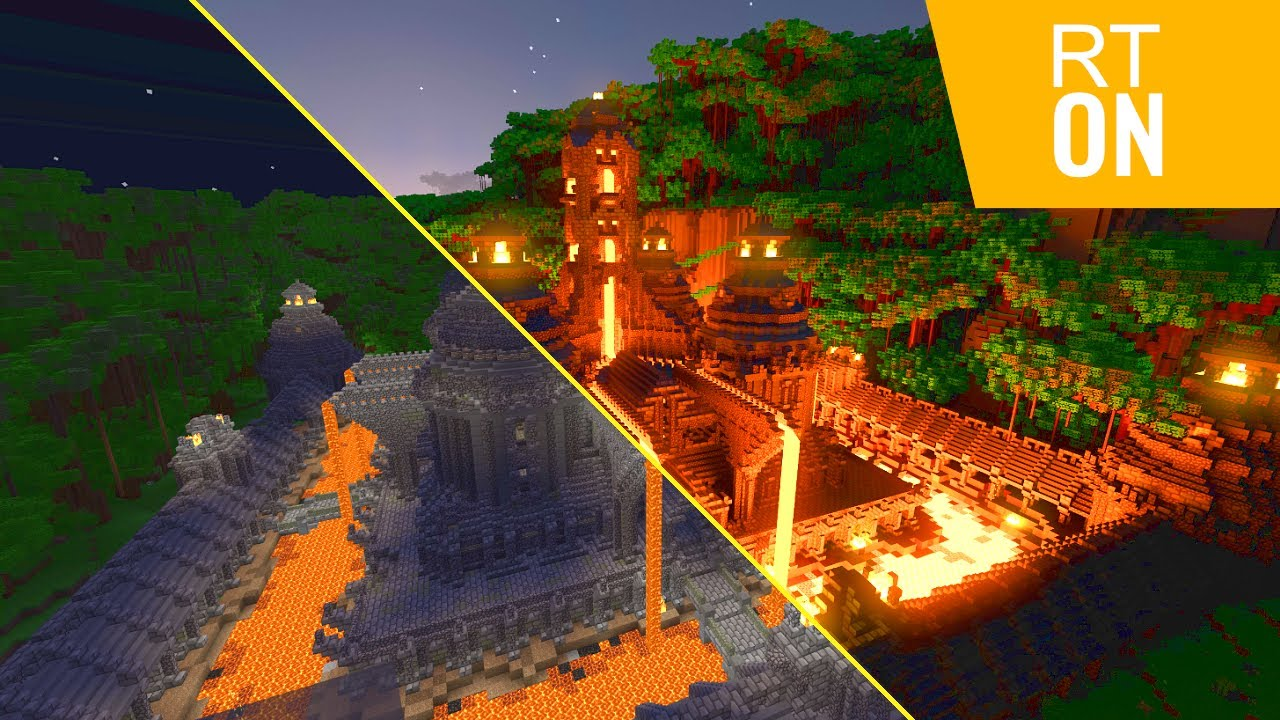

Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D9qxfavtUs7w&psig=AOvVaw29xEcLp5n-QbSNL2TYHlZ_&ust=1734839166380000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCOCqktf5t4oDFQAAAAAdAAAAABAE

---

## How NeRF Combines NeRF and Ray Tracing

1. **Ray Marching**:
   - Rays are cast through each pixel of the input images, and NeRF samples points along each ray.
   - These sampled points are encoded and processed by the neural network to compute radiance and density.

2. **Rendering**:
   - NeRF uses the volume rendering equation to integrate radiance and density along each ray.
   - This process simulates the accumulation of light and color as the ray traverses the scene.

3. **Optimization**:
   - The NeRF model is trained by minimizing the difference between rendered pixel values and ground truth pixel values from input images.
   - This optimization enables the model to accurately reconstruct the scene and generate novel views.

### Key Concepts of NeRF:
1. **Scene Representation**:
   - NeRF represents a scene as a continuous volumetric field.
   - Each point in 3D space is characterized by its color (RGB) and volumetric density.

2. **Ray Marching and Volume Rendering**:
   - Rays are cast from the camera through the 3D scene, accumulating color and opacity along their paths.
   - Volume rendering integrates the contributions of sampled points along each ray to compute the final pixel color.

3. **Neural Network Parameterization**:
   - A fully connected neural network learns to map spatial coordinates (x, y, z) and view direction to radiance (color) and density.

4. **Optimization**:
   - NeRF is trained to minimize the reconstruction error between the predicted pixel colors and the ground truth pixel colors in the input images.

### Applications of NeRF:
1. **Novel View Synthesis**: Rendering views of a scene from perspectives not present in the training data.
2. **3D Scene Reconstruction**: Capturing detailed 3D geometry from sparse input data.
3. **Augmented Reality (AR) and Virtual Reality (VR)**: Creating immersive 3D content from real-world scenes.

### Challenges:
1. **Computational Cost**: NeRFs require a large number of samples per ray, making training computationally intensive.
2. **Sparse Input Views**: Performance degrades with fewer input images.
3. **Real-time Rendering**: Achieving real-time inference remains an active area of research.

---

### What Will This Notebook Cover?
1. **3D Rendering Fundamentals**:
   - Basics of ray tracing and volume rendering.
   - How NeRF integrates these principles.

2. **Neural Network for NeRF**:
   - Building a simple NeRF model using PyTorch.
   - Mapping spatial coordinates and view directions to RGB and density.

3. **Optimization and Training**:
   - Defining loss functions and optimizing the model to minimize reconstruction error.

4. **Novel View Synthesis**:
   - Generating novel views from the learned NeRF model.

---


We will use PyTorch for building and training the NeRF model and Matplotlib for visualizing the results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Building the NeRF Model
The NeRF model consists of a fully connected neural network that maps:
1. Spatial coordinates (x, y, z)
2. View direction (theta, phi)
To:
- **RGB Color**: Represents the color of the point when viewed from the given direction.
- **Density**: Represents how much light is absorbed at the point.

Key Components:
- **Positional Encoding**: Enhances the network's ability to model high-frequency details.
- **Fully Connected Layers**: Approximate the radiance field.

In [24]:
class NeRF(nn.Module):
    def __init__(self, depth=8, width=256, input_dim=63):
        super(NeRF, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            in_features = input_dim if i == 0 else width
            self.layers.append(nn.Linear(in_features, width))
            self.layers.append(nn.ReLU())
        self.output_layer = nn.Linear(width, 4)  # Output: RGB (3) + Density (1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        outputs = self.output_layer(x)
        rgb = torch.sigmoid(outputs[..., :3])  # Normalize RGB values
        density = torch.relu(outputs[..., 3:4])  # Ensure density is non-negative
        return torch.cat([rgb, density], dim=-1)




model = NeRF().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

### Positional Encoding

Positional encoding is a technique used to represent input coordinates (x, y, z) and view directions in a higher-dimensional space. This allows the model to capture fine details and represent high-frequency information.

We use sinusoidal functions of different frequencies to encode the input.

In [7]:
def positional_encoding(x, num_freqs=10):
    encodings = [x]
    for i in range(num_freqs):
        for fn in [torch.sin, torch.cos]:
            encodings.append(fn(2.0 ** i * x))
    return torch.cat(encodings, dim=-1)

# Example output shape for positional encoding
sample_input = torch.tensor([[0.5, 0.2, 0.8]])
pos_encoded = positional_encoding(sample_input)
print(f"Positional Encoding Shape: {pos_encoded.shape}")


Positional Encoding Shape: torch.Size([1, 63])


We can see that positional encoding successfully represented our input coordinates and translated them to higher-dimensional space (1, 63).

### Ray Sampling and Volume Rendering

1. **Ray Sampling**:
   - Rays are cast from the camera through each pixel.
   - For each ray, we sample points along its path.

2. **Volume Rendering**:
   - Integrate the contributions of sampled points along the ray to compute the pixel color.

Key Equation:
$C(r) = \int_{t_n}^{t_f} T(t) \sigma(t) c(t) dt$
Where:
- $T(t)$: Transmittance along the ray.
- $\sigma(t)$: Density at point $t$.
- $c(t)$: Color at point $t$.

---

The `render_rays_with_density` function computes pixel colors and accumulated density values by sampling points along the generated rays. This function is a critical part of rendering scenes in NeRF, as it integrates information from sampled points along each ray.

### Key Components:
1. **Inputs**:
   - `ray_origins` and `ray_directions`: Define the starting point and direction for each ray.
   - `model`: The NeRF model, which maps spatial coordinates to RGB and density values.
   - `num_samples`: The number of points sampled along each ray.
   - `noise_std`: Standard deviation for noise added to density during training, enhancing learning stability.

2. **Outputs**:
   - `pixel_colors`: The final rendered color for each ray, computed by integrating RGB values.
   - `accumulated_density`: The total density accumulated along each ray, representing opacity.

### Function Logic:
- **Ray Sampling**:
  - Points are sampled along each ray at regular intervals based on `num_samples`.
- **Model Inference**:
  - The sampled points are passed through the NeRF model to obtain RGB and density values.
- **Transmittance and Weights**:
  - The density values are used to compute transmittance (how much light passes through) and weights for each sampled point.
- **Volume Rendering**:
  - Weighted integration of RGB values produces the final pixel colors.
  - The sum of weights gives the accumulated density.

In [31]:
def render_rays_with_density(ray_origins, ray_directions, model, num_samples=64, noise_std=1e-3):
    t_vals = torch.linspace(0, 1, steps=num_samples).to(ray_origins.device)
    samples = ray_origins[..., None, :] + t_vals[None, :, None] * ray_directions[..., None, :]
    samples_flat = samples.view(-1, 3)

    encoded_samples = positional_encoding(samples_flat)
    outputs = model(encoded_samples)
    rgb, density = outputs[..., :3], outputs[..., 3:]

    if model.training and noise_std > 0:
        density += torch.randn_like(density) * noise_std

    # Normalize RGB
    rgb = torch.sigmoid(rgb)

    # Reshape outputs
    density = density.view(ray_origins.shape[0], num_samples, 1)
    rgb = rgb.view(ray_origins.shape[0], num_samples, 3)

    # Compute transmittance and weights
    delta = t_vals[1] - t_vals[0]
    alpha = 1.0 - torch.exp(-density * delta)
    transmittance = torch.cumprod(torch.cat([torch.ones_like(alpha[:, :1]), 1.0 - alpha + 1e-10], dim=1), dim=1)[:, :-1]
    weights = alpha * transmittance

    pixel_colors = torch.sum(weights * rgb, dim=1)

    # Accumulated opacity (density integration)
    accumulated_density = torch.sum(weights, dim=1)
    return pixel_colors, accumulated_density



The `generate_rays_with_pattern` function is responsible for generating ray origins and directions for rendering scenes. It allows for creating specific patterns, such as a circular region or a checkerboard, which can help visualize how the rays interact with the scene.

### Key Components:
1. **Inputs**:
   - `image_size`: Tuple defining the height and width (\(H, W\)) of the grid, corresponding to the resolution of the rendered image.
   - `focal_length`: The focal length of the virtual camera, determining the spread of the rays.
   - `device`: Specifies whether computations will be performed on a CPU or GPU.
   - `pattern`: Specifies the type of ray pattern to generate (`"circle"` or `"checkerboard"`).

2. **Outputs**:
   - `origins`: Tensor of ray origins, typically at the origin of the scene.
   - `directions`: Tensor of ray directions, pointing outward based on the pattern.

- A grid of pixel coordinates is generated using `torch.meshgrid`, representing the rays across the image.
- Depending on the chosen pattern:
  - **Circular Pattern**:
    - A circular mask is applied to include only rays originating within a specified radius from the center of the grid.
    - Directions outside this region are set to zero, creating a visually distinct circular region.
  - **Checkerboard Pattern**:
    - Alternating blocks of the grid are activated, forming a checkerboard-like pattern.
    - Active and inactive rays alternate in a regular grid.
  - **Default Pattern**:
    - All rays are generated without any specific masking.


In [39]:
def generate_rays_with_pattern(image_size, focal_length, device, pattern="circle"):
    H, W = image_size
    i, j = torch.meshgrid(
        torch.arange(0, H, device=device), torch.arange(0, W, device=device), indexing="ij"
    )

    if pattern == "circle":
        center = torch.tensor([H / 2, W / 2], device=device)
        radius = min(H, W) / 4
        mask = ((i - center[0])**2 + (j - center[1])**2) < radius**2
        directions = torch.stack([
            (j - W / 2) / focal_length,
            -(i - H / 2) / focal_length,
            -torch.ones_like(i)
        ], dim=-1)
        directions = directions * mask[..., None]  # Apply mask to directions
    elif pattern == "checkerboard":
        mask = ((i // 10 % 2) == (j // 10 % 2)).float()
        directions = torch.stack([
            (j - W / 2) / focal_length,
            -(i - H / 2) / focal_length,
            -torch.ones_like(i)
        ], dim=-1)
        directions = directions * mask[..., None]  # Apply mask to directions
    else:
        directions = torch.stack([
            (j - W / 2) / focal_length,
            -(i - H / 2) / focal_length,
            -torch.ones_like(i)
        ], dim=-1)

    origins = torch.zeros_like(directions)
    return origins, directions


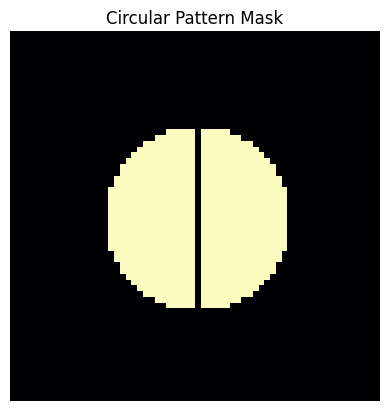

In [46]:
image_size = (64, 64)
focal_length = 50.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ray_origins, ray_directions = generate_rays_with_pattern(image_size, focal_length, device, pattern="circle")

mask = (ray_directions[..., 0] != 0).float().detach().cpu().numpy().reshape(image_size)
plt.imshow(mask, cmap="magma")
plt.title("Circular Pattern Mask")
plt.axis("off")
plt.show()


The circular pattern mask is a visualization of the rays included in the rendering process. It highlights how the rays are selectively enabled in a circular region centered in the grid. The mask is a binary grid where rays within the circle are active (value of 1), and others are inactive (value of 0).


# Exercises

### 1. Modify the Sampling Resolution
- Change the number of points sampled along each ray in the `render_rays_with_density` function from 64 to 128. Observe how this affects the rendering quality and computational performance.
- **Hint:** Adjust the `num_samples` parameter when calling the `render_rays_with_density` function.


### 2. Implement a Custom Pattern for Rays
- Add a new pattern to the `generate_rays_with_pattern` function, such as a diagonal stripe pattern.
- **Hint:** Use a combination of the row (`i`) and column (`j`) indices to create a diagonal stripe mask.


### 3. Experiment with Positional Encoding Frequencies
- Reduce the number of frequencies used in the `positional_encoding` function from 10 to 5. Observe how this impacts the rendered image quality.
- **Hint:** Modify the `num_freqs` parameter in the `positional_encoding` function and test it with a simple ray pattern.


### 4. Analyze the Effect of Noise
- Experiment with different values of `noise_std` in the `render_rays_with_density` function during training. Visualize how the accumulated density changes with and without noise.
- **Hint:** Use `noise_std=0.0` and `noise_std=1e-3` in separate runs and compare the results.


### 5. Add a Visualization for Accumulated Weights
- Extend the `render_rays_with_density` function to return the weights computed during volume rendering. Visualize these weights as a heatmap for the circular ray pattern.
- **Hint:** The weights are calculated using `alpha * transmittance`. Store and return them for visualization.

